In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel,TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#set plot options
plt.rcParams['figure.figsize']=(12,8)
default_plot_colour="#EA4DDD"

In [4]:
data=pd.read_csv("fake_news_data.csv")

In [5]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


Text(0.5, 1.0, 'Count of Article Classification')

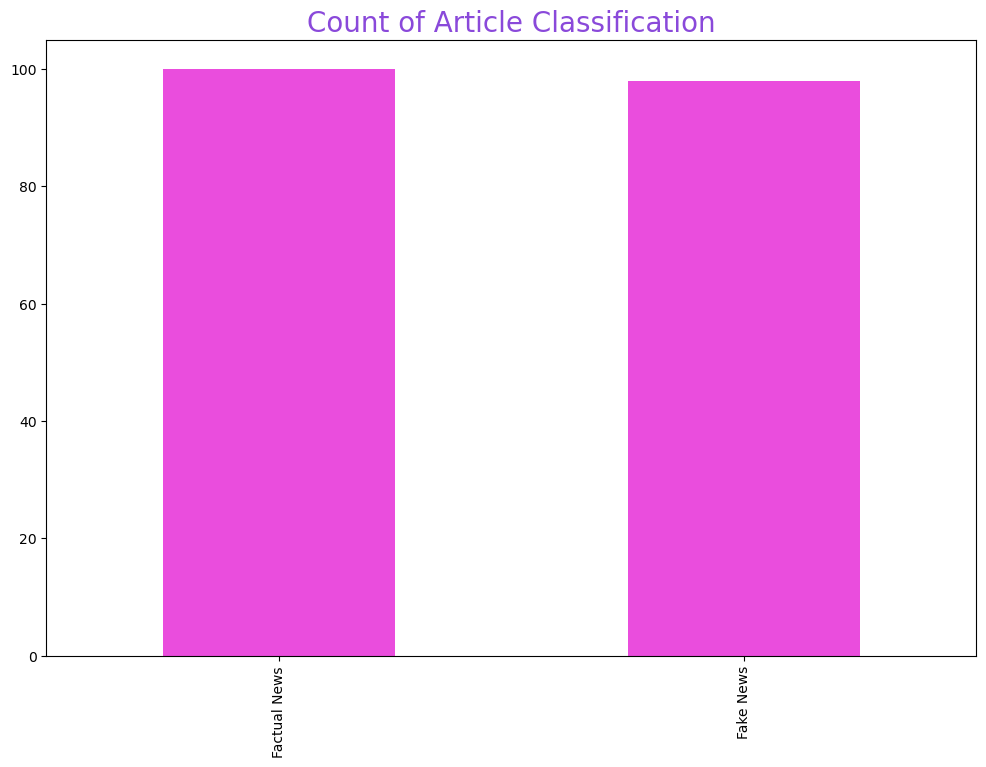

In [7]:
data['fake_or_factual'].value_counts().plot.bar(color=default_plot_colour)#or we can write .plot(kind="bar",...)
plt.title("Count of Article Classification",color="#8A49DA",fontsize=20)

# POS Tagging

In [8]:
nlp=spacy.load('en_core_web_sm')

In [9]:
fake_news=data[data['fake_or_factual']=='Fake News']
fact_news=data[data['fake_or_factual']=='Factual News']

In [10]:
fake_spacydocs=list(nlp.pipe(fake_news['text']))
fact_spacydocs=list(nlp.pipe(fact_news['text']))

In [11]:
def extract_token_tags(doc:spacy.tokens.doc.Doc):
    return[(i.text,i.ent_type_,i.pos_)for i in doc]

In [12]:
fake_tagsdf=[]
columns=["token","ner_tag","pos_tag"]

In [13]:
for ix,doc in enumerate(fake_spacydocs):
    tags=extract_token_tags(doc)
    tags=pd.DataFrame(tags)
    tags.columns=columns
    fake_tagsdf.append(tags)

In [14]:
fake_tagsdf=pd.concat(fake_tagsdf)

In [15]:
fake_tagsdf

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN
...,...,...,...
743,.,,PUNCT
744,Via,,NOUN
745,:,,PUNCT
746,Campus,,PROPN


In [16]:
fact_tagsdf=[]
for ix,doc in enumerate(fact_spacydocs):
    tags=extract_token_tags(doc)
    tags=pd.DataFrame(tags)
    tags.columns=columns
    fact_tagsdf.append(tags)

In [17]:
fact_tagsdf=pd.concat(fact_tagsdf)

In [18]:
fact_tagsdf

,token,ner_tag,pos_tag
0,WASHINGTON,GPE,PROPN
1,(,,PUNCT
2,Reuters,ORG,PROPN
3,),,PUNCT
4,-,,PUNCT
...,...,...,...
85,citing,,VERB
86,three,CARDINAL,NUM
87,unnamed,,ADJ
88,officials,,NOUN


In [19]:
pos_count_fake=fake_tagsdf.groupby(['token','pos_tag']).size().reset_index(name="counts").sort_values(by="counts",ascending=False)
pos_count_fake.head()

,token,pos_tag,counts
28,",",PUNCT,1908
7446,the,DET,1834
39,.,PUNCT,1531
5759,of,ADP,922
2661,and,CCONJ,875


In [20]:
pos_count_fact=fact_tagsdf.groupby(['token','pos_tag']).size().reset_index(name="counts").sort_values(by="counts",ascending=False)

In [21]:
pos_count_fact.groupby('pos_tag')['token'].count().sort_values(ascending=False).head()

pos_tag
NOUN     2182
VERB     1535
PROPN    1387
ADJ       753
ADV       271
Name: token, dtype: int64

In [22]:
pos_count_fake.groupby('pos_tag')['token'].count().sort_values(ascending=False).head()

pos_tag
NOUN     2597
VERB     1814
PROPN    1657
ADJ       876
ADV       412
Name: token, dtype: int64

In [23]:
pos_count_fact[pos_count_fact.pos_tag=="NOUN"][:15]

,token,pos_tag,counts
3748,government,NOUN,71
6639,year,NOUN,64
5927,state,NOUN,58
2373,bill,NOUN,55
1982,administration,NOUN,51
3289,election,NOUN,48
5084,president,NOUN,47
4804,order,NOUN,45
4937,people,NOUN,45
2509,campaign,NOUN,42


# Named Entities

In [24]:
top_entities_fake=fake_tagsdf[fake_tagsdf['ner_tag'] !=""].groupby(['token','ner_tag']).size().reset_index(name="counts").sort_values(by="counts",ascending=False)

In [25]:
top_entities_fact=fact_tagsdf[fact_tagsdf['ner_tag'] !=""].groupby(['token','ner_tag']).size().reset_index(name="counts").sort_values(by="counts",ascending=False)

In [26]:
top_entities_fact.head()

,token,ner_tag,counts
1624,Trump,ORG,195
1986,the,ORG,154
1645,U.S.,GPE,138
1383,Reuters,ORG,131
880,House,ORG,68


In [27]:
ner_palette={
    'ORG':sns.color_palette("Set2").as_hex()[0],
    'GPE':sns.color_palette("Set2").as_hex()[1],
    'NORP':sns.color_palette("Set2").as_hex()[2],
    'PERSON':sns.color_palette("Set2").as_hex()[3],
    'DATE':sns.color_palette("Set2").as_hex()[4],
    'CARDINAL':sns.color_palette("Set2").as_hex()[5],
    'PERCENT':sns.color_palette("Set2").as_hex()[6],
}

[Text(0.5, 1.0, 'Most Common Named Entities in Fake News')]

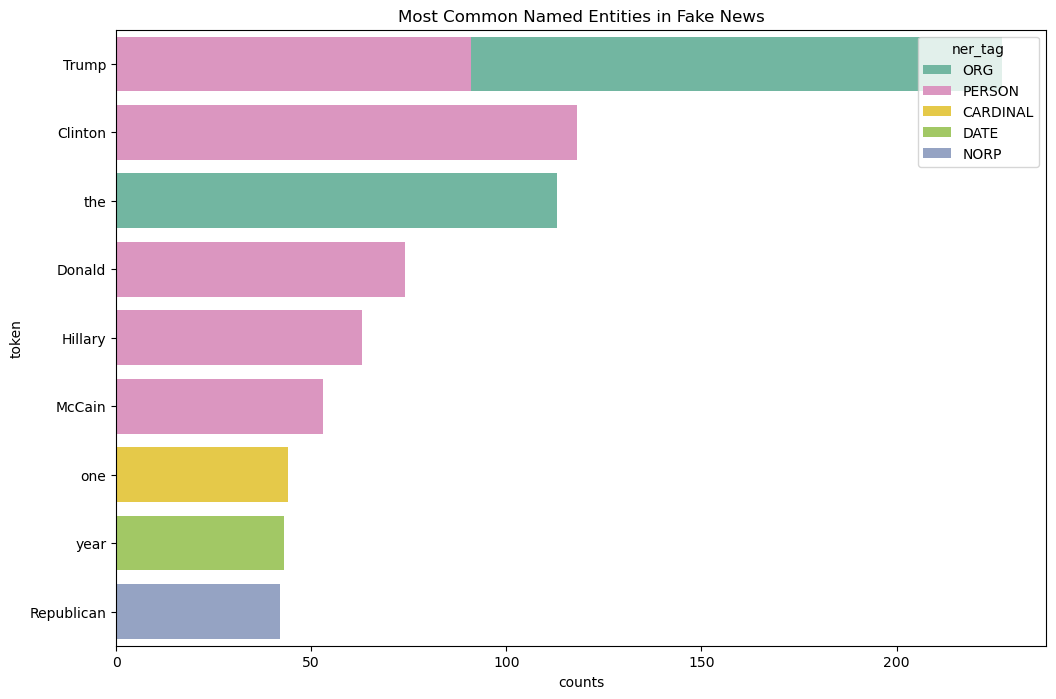

In [28]:
sns.barplot(
x='counts',
y='token',
hue='ner_tag',
palette=ner_palette,
data=top_entities_fake[:10],
orient='h',
dodge=False).set(title="Most Common Named Entities in Fake News")

[Text(0.5, 1.0, 'Most Common Named Entities in factual News')]

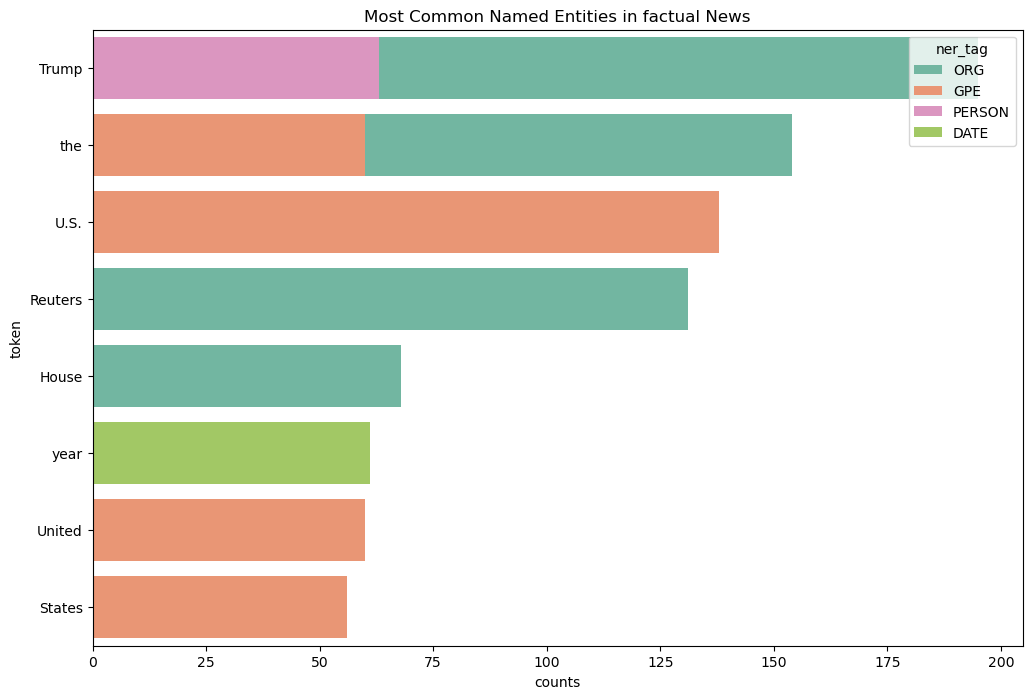

In [29]:
sns.barplot(
x='counts',
y='token',
hue='ner_tag',
palette=ner_palette,
data=top_entities_fact[:10],
orient='h',
dodge=False).set(title="Most Common Named Entities in factual News")

# Text Pre-Processing

In [30]:
data['text_clean']=data.apply(lambda x:re.sub(r"^[^-]*-\s","",x['text']),axis=1)

In [31]:
data['text_clean']=data['text_clean'].str.lower()

In [32]:
data['text_clean']=data.apply(lambda x:re.sub(r"([^\w\s])","",x['text_clean']),axis=1)

In [33]:
en_stopwords=stopwords.words('english')

In [34]:
data['text_clean']=data['text_clean'].apply(lambda x:' '.join([word for word in x.split() if word not in (en_stopwords)]))

In [35]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,two small problems analogy susan jesus muslim ...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried trump bonkers interview new york times ...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,women make 50 percent country grossly underrep...
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,us defense secretary jim mattis said monday ru...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland political parties rapidly run...


In [36]:
data['text_clean']=data.apply(lambda x: word_tokenize(x['text_clean']),axis=1)

In [37]:
lemmatizer=WordNetLemmatizer()
data['text_clean']=data['text_clean'].apply(lambda tokens:[lemmatizer.lemmatize(token) for token in tokens])

In [38]:
tokens_clean=sum(data['text_clean'],[])

In [39]:
unigrams=(pd.Series(nltk.ngrams(tokens_clean,1)).value_counts())
print(unigrams[:10])

(trump,)         580
(said,)          580
(u,)             277
(state,)         275
(president,)     259
(would,)         226
(one,)           160
(clinton,)       141
(year,)          139
(republican,)    137
dtype: int64


[Text(0.5, 1.0, 'Most Common unigrams after Preprocessing')]

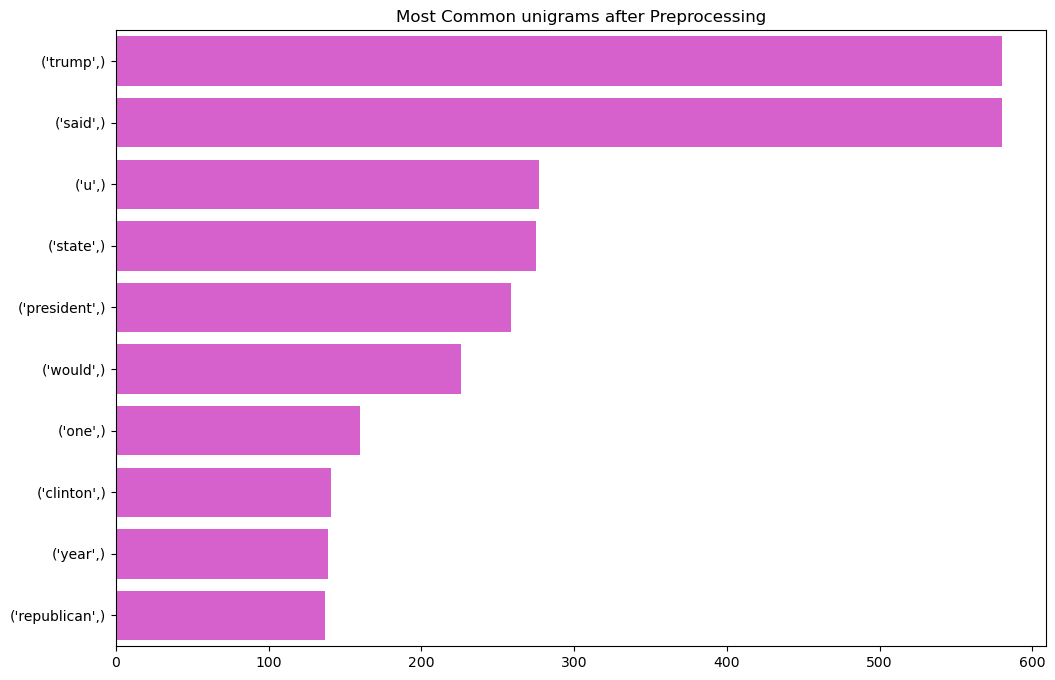

In [40]:
sns.barplot(x=unigrams.values[:10],
           y=unigrams.index[:10],
           orient='h',
           palette=[default_plot_colour]).set(title="Most Common unigrams after Preprocessing")

# Sentiment Analysis

In [41]:
vader_sentiment=SentimentIntensityAnalyzer()


In [42]:
data['vader_sentiment_score']=data['text'].apply(lambda x: vader_sentiment.polarity_scores(x)['compound'])

In [43]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


In [44]:
bins=[-1,-0.1,0.1,1]
names=['negative','neutral','positive']

In [45]:
data['vader_sentiment_label']=pd.cut(data['vader_sentiment_score'],bins,labels=names)

In [46]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


<AxesSubplot:>

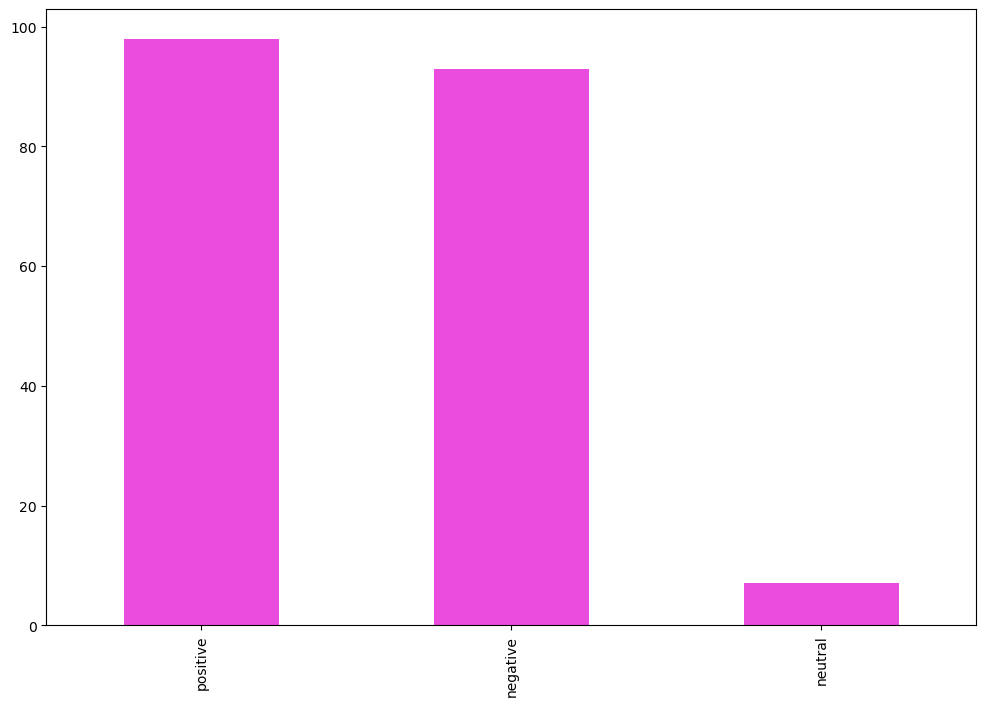

In [47]:
data['vader_sentiment_label'].value_counts().plot.bar(color=default_plot_colour)

[Text(0.5, 1.0, 'Sentiment By news type')]

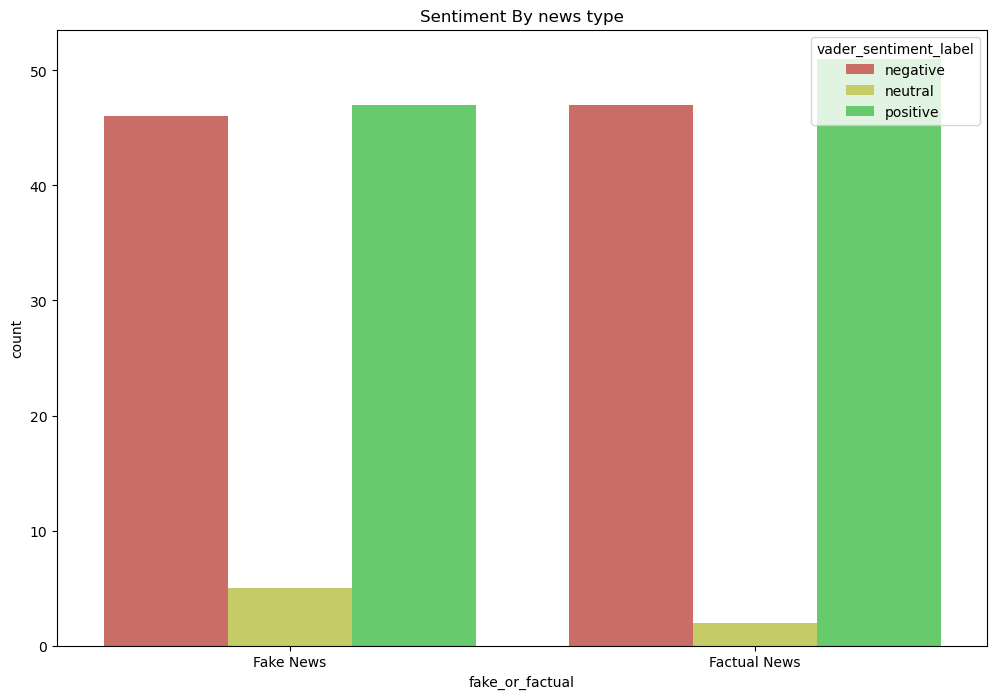

In [48]:
sns.countplot(x="fake_or_factual",
               hue='vader_sentiment_label',
               palette=sns.color_palette("hls"),
             data=data).set(title="Sentiment By news type")

# Topic Modelling

In [49]:
fake_new_text=data[data['fake_or_factual']=="Fake News"]['text_clean'].reset_index(drop=True)

In [50]:
dictionary_fake=corpora.Dictionary(fake_new_text)

In [51]:
doc_term_fake=[dictionary_fake.doc2bow(text)for text in fake_new_text]

In [52]:
coherence_values=[]
model_list=[]
min_topics=2
max_topics=11

for num_topics_i in range(min_topics,max_topics+1):
    model=gensim.models.LdaModel(doc_term_fake,num_topics=num_topics_i,id2word=dictionary_fake)
    model_list.append(model)
    coherence_model=CoherenceModel(model=model,texts=fake_new_text,dictionary=dictionary_fake,coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

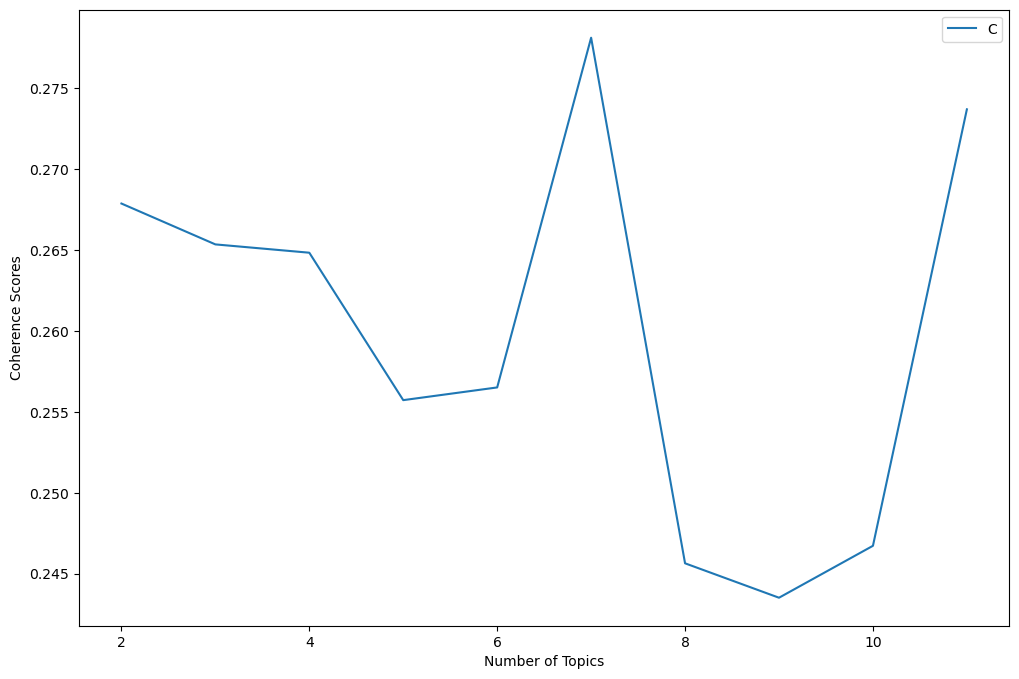

In [53]:
plt.plot(range(min_topics,max_topics+1),coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Scores")
plt.legend(("Coherence_values"),loc='best')
plt.show()

In [54]:
num_topics_lda=2
lda_model=gensim.models.LdaModel(corpus=doc_term_fake,id2word=dictionary_fake,num_topics=num_topics_lda)

In [55]:
lda_model.print_topics(num_topics=num_topics_lda,num_words=10)

[(0,
  '0.005*"trump" + 0.004*"u" + 0.004*"president" + 0.003*"said" + 0.003*"year" + 0.003*"clinton" + 0.003*"would" + 0.003*"one" + 0.003*"obama" + 0.003*"state"'),
 (1,
  '0.015*"trump" + 0.005*"said" + 0.005*"state" + 0.005*"president" + 0.005*"clinton" + 0.004*"would" + 0.004*"one" + 0.004*"time" + 0.003*"donald" + 0.003*"woman"')]

In [56]:
def tfidf_corpus(doc_term_matrix):
    tfidf=TfidfModel(corpus=doc_term_matrix,normalize=True)
    corpus_tfidf=tfidf[doc_term_matrix]
    return corpus_tfidf

In [57]:
def get_coherence_scores(corpus,dictionary,text,min_topics,max_topics):
    coherence_values=[]
    model_list=[]
    for num_topics_i in range(min_topics,max_topics+1):
        model=LsiModel(corpus,num_topics=num_topics_i,id2word=dictionary)
        model_list.append(model)
        coherence_model=CoherenceModel(model=model,texts=text,dictionary=dictionary,coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    plt.plot(range(min_topics,max_topics+1),coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"),loc="best")
    plt.show()

In [58]:
corpus_tfidf_fake=tfidf_corpus(doc_term_fake)

In [ ]:
get_coherence_scores(corpus_tfidf_fake,dictionary_fake,fake_new_text,min_topics=2,max_topics=11)

In [ ]:
lsa_model=LsiModel(corpus_tfidf_fake,id2word=dictionary_fake,num_topics=2)

In [ ]:
lsa_model.print_topics()

# Creating our Classification Model

In [ ]:
X=[','.join(map(str,l))for l in data['text_clean']]

In [ ]:
Y=data['fake_or_factual']

In [ ]:
countve=CountVectorizer()

In [ ]:
countve_fit=countve.fit_transform(X)

In [ ]:
bag_ofowords=pd.DataFrame(countve_fit.toarray(),columns=countve.get_feature_names_out())

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(bag_ofowords,Y,test_size=0.3)

## Logistic regression Classifier

In [ ]:
lr=LogisticRegression(random_state=0).fit(X_train,y_train)

In [ ]:
y_pred_lr=lr.predict(X_test)

In [ ]:
accuracy_score(y_pred_lr,y_test)

In [ ]:
print(classification_report(y_test,y_pred_lr))

## SVM Classifier

In [ ]:
svm=SGDClassifier().fit(X_train,y_train)

In [ ]:
y_pred_svm=svm.predict(X_test)

In [ ]:
accuracy_score(y_pred_svm,y_test)

In [ ]:
print(classification_report(y_test,y_pred_svm))